1.0 Data collection

In [ ]:
!pip install kaggle
!pip install pandas
!pip install seaborn
!pip install pansql

In [15]:
import os
import subprocess
import zipfile
import pandas as pd
import seaborn as sns
color_pallate = sns.color_palette()
import matplotlib.pyplot as plt
import pansql as ps

In [2]:
PATH  = 'robikscube/hourly-energy-consumption'
DATA = 'Kaggle_DEC'

In [3]:
!kaggle datasets download -d {PATH}

hourly-energy-consumption.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
def download_dataset(path):
    # Run the command and capture the output
    result = subprocess.run(['kaggle', 'datasets', 'download', '-d', path], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    output = result.stdout.decode('utf-8')

    print(output)  # For debugging, to see what the output is

    # Extract the filename from the path
    filename = path.split('/')[-1] + '.zip'
    return filename

path = PATH
zip_file_name = download_dataset(path)
zip_file_name

hourly-energy-consumption.zip: Skipping, found more recently modified local copy (use --force to force download)



'hourly-energy-consumption.zip'

In [5]:
with zipfile.ZipFile(zip_file_name,'r') as zip_ref:
    zip_ref.extractall(DATA)

2.0 Data preprocessing

In [6]:
df = pd.read_csv(DATA + '/PJME_hourly.csv')

In [7]:
df.set_index('Datetime', inplace=True)

In [8]:
print(df.index.dtype)
df.index = pd.to_datetime(df.index)
df.head()

object


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


3.0 EDA

<Axes: title={'center': 'Energy consumption'}, xlabel='Datetime'>

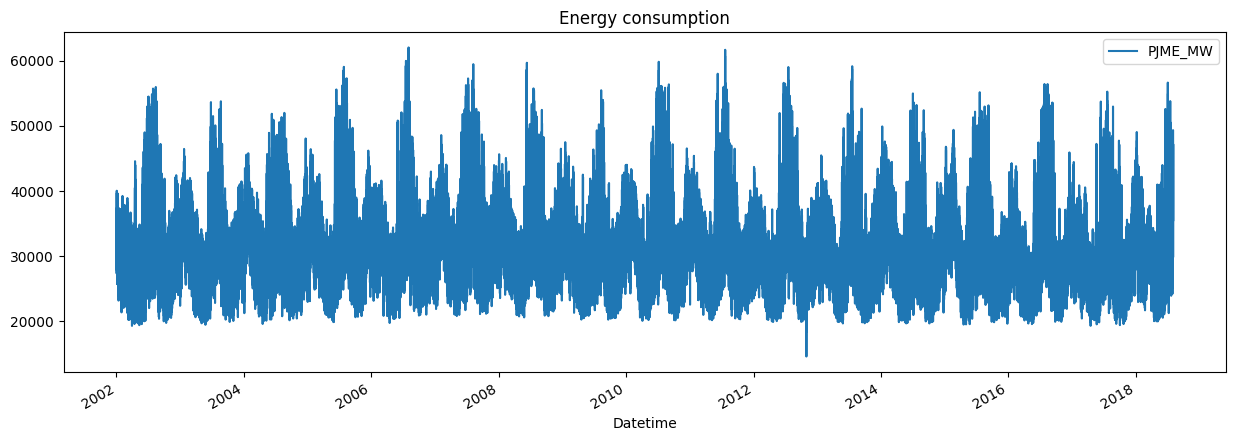

In [9]:
df.plot(figsize=(15, 5), 
        color = color_pallate[0], 
        title='Energy consumption')

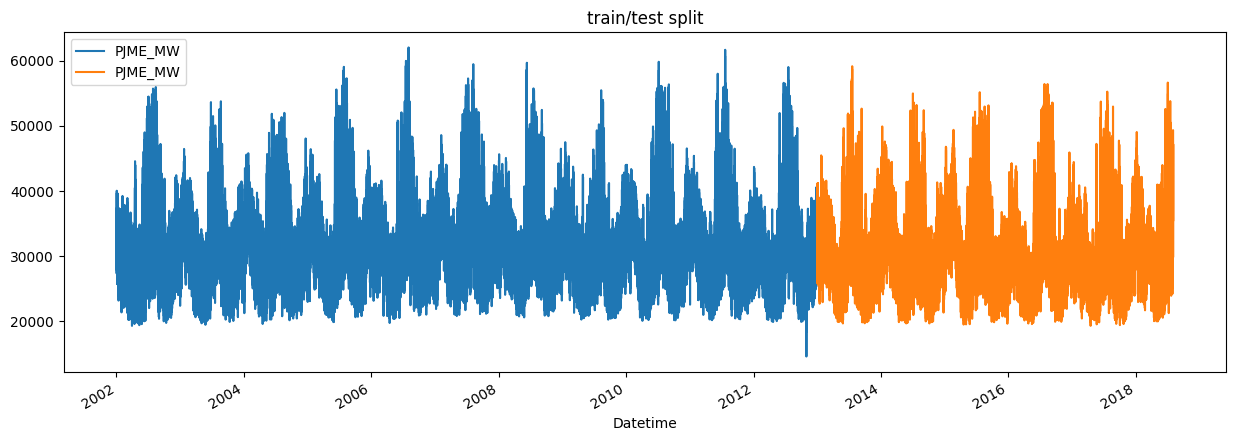

In [10]:
train = df.loc[df.index < '2013-01-01']
test = df.loc[df.index >= '2013-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, color=color_pallate[0], label='train', title='train/test split')
test.plot(ax=ax, color=color_pallate[1], label='test')
plt.show()

In [11]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    return df


In [12]:
train = create_features(train)
test = create_features(test)

In [13]:
train.head()

,PJME_MW,hour,day,month,year,dayofweek
Datetime,,,,,,
2002-12-31 01:00:00,26498.0,1,31,12,2002,1
2002-12-31 02:00:00,25147.0,2,31,12,2002,1
2002-12-31 03:00:00,24574.0,3,31,12,2002,1
2002-12-31 04:00:00,24393.0,4,31,12,2002,1
2002-12-31 05:00:00,24860.0,5,31,12,2002,1


In [23]:
query = '''
SELECT *
FROM test
WHERE dayofweek = 0
AND day <=7
AND year = 2013
AND month = 12
'''

a1 = ps.sqldf(query)
a1.head(1)

,Datetime,PJME_MW,hour,day,month,year,dayofweek
0,2013-12-02 01:00:00.000000,26317.0,1,2,12,2013,0


<Axes: title={'center': 'sample of energy consumption for a week'}, xlabel='Datetime'>

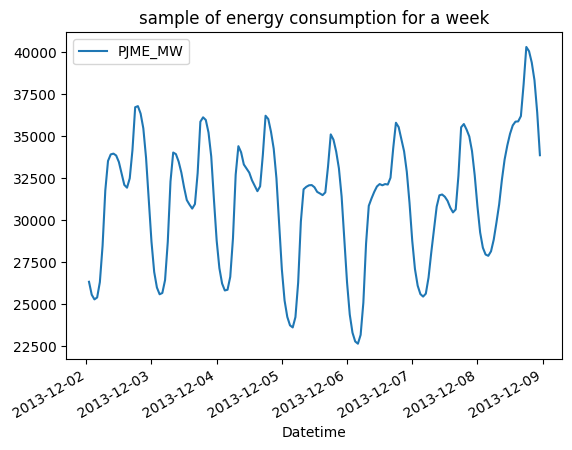

In [36]:
df.loc[(df.index > '2013-12-02') & (df.index < '2013-12-09')].plot(title='sample of energy consumption for a week')

<Axes: title={'center': 'sample of energy consumption for a day'}, xlabel='Datetime'>

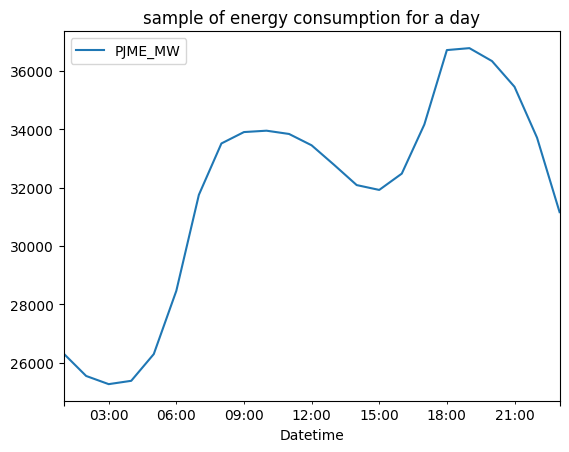

In [35]:
df.loc[(df.index > '2013-12-02') & (df.index < '2013-12-03')].plot(title='sample of energy consumption for a day')

In [38]:
df = create_features(df)

<Axes: xlabel='hour', ylabel='PJME_MW'>

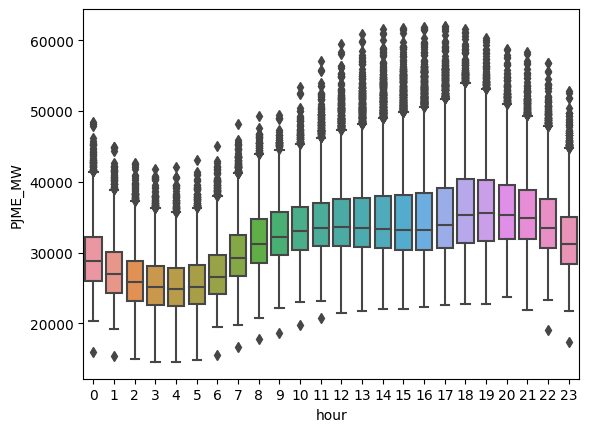

In [40]:
sns.boxplot(data=df, x='hour', y='PJME_MW')

<Axes: xlabel='dayofweek', ylabel='PJME_MW'>

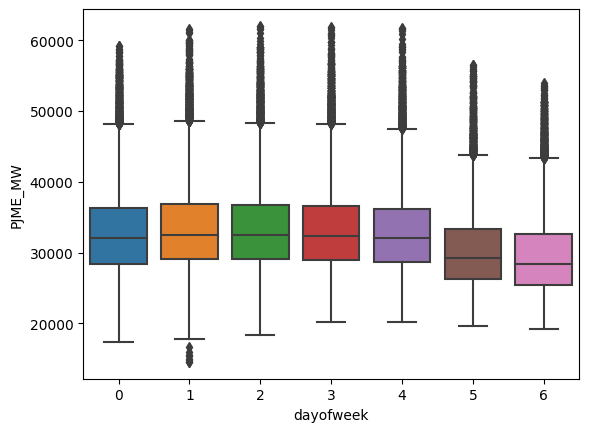

In [41]:
sns.boxplot(data=df, x='dayofweek', y='PJME_MW')

<Axes: xlabel='month', ylabel='PJME_MW'>

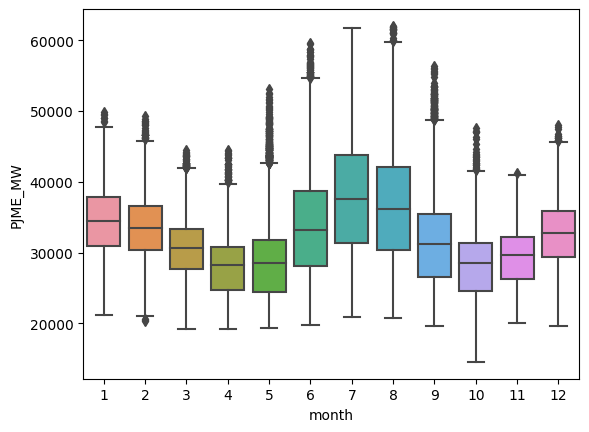

In [42]:
sns.boxplot(data=df, x='month', y='PJME_MW')

4.0 Modelling

In [44]:
train.columns

Index(['PJME_MW', 'hour', 'day', 'month', 'year', 'dayofweek'], dtype='object')

In [45]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'day', 'month', 'year', 'dayofweek']
TARGET = 'PJME_MW'

In [46]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

5.0 Forecasting